# Neural PDE solvers

### Consider a system with its dynamics following the initial-boundary value problem for 1d transfer equation

\begin{gather*}
\dfrac{\partial u}{\partial t} + a(x, t) \dfrac{\partial u}{\partial x} = 0, \quad u = u(x, t) \\ 
u(x, 0) = u_0(x) \\
u(0, t) = u_1(t) = 0 \\\
x \in [0, 1], \quad t \in [0, 1]
\end{gather*}

with unknown function $a(x, t)$. Our target is to approximate this function, given a set of observations of the system states in different periods of time $\{\hat{u}(t_i), \, i \in \overline{1, K} \} $.

We approximate the partial differential equation (PDE) with a simple finite difference scheme (FDS) on a uniform grid 

\begin{gather*} 
\omega = \left\{ih, j\tau, \, j \in \overline{1,N}, j \in \overline{1, M}, \tau M = 1, hN = 1  \right\} \\ 
u_{i+1}^{j+1} = u_{i+1}^{j} - \dfrac{a(n\tau, hi) \cdot \tau}{h} \left( u_{i+1}^{n} - u_{i}^{n} \right) 
\end{gather*}

### Let's replace function $a$ with a neural net 
$$ a(x, t) = \text{NN} (x, t)$$
##### and simply use it as a callable function for FD scheme.

$$ u_{i+1}^{n+1} = u_{i+1}^{n} -\dfrac{\text{NN}(n\tau, hi) \cdot \tau}{h} \left( u_{i+1}^{n} - u_{i}^{n} \right) $$

### Training procedure for our neural network may vary depending from the available observations 
If we can get the observations on the whole grid $\omega$, then the training process may be organized the following way 
1. Sample a triplet of $\left( t_n, u^n, u^{n+p} \right)$
2. Unroll p steps of parameterized FDS $$\tilde{u}^{n+p} = FDS(u^n) $$
3. Compare with ground truth via loss function and backprop
$$\text{L} = \text{L} \left(\tilde{u}^{n+p}, u^{n+p}) \right) $$

Otherwise,
1. Sample a pair $\left( t_n, \hat{u}^n \right)$
2. Run n steps of parameterized FDS 
    $$\tilde{u}^{n} = FDS(u_0) $$
3. Get the available observation with projecting the numerical solution
4. Compare with ground truth via loss function and backprop $\text{L} = \text{L} \left(\text{obs} \left( \tilde{u}^{n} \right), \hat{u}^n \right) $

###  Let's try the proposed method on the problem with a constant transfer speed

\begin{gather*}
\dfrac{\partial u}{\partial t} + a \dfrac{\partial u}{\partial x} = 0, \quad u = u(x, t), \quad a = 1 \\ 
u(x, 0) = u_0(x) \\
u(0, t) = u_1(t) = 0 \\\
x \in [0, 1], \quad t \in [0, 1]
\end{gather*}

The exact solution of the problem is given by
$$u(x, t) = u_0(x + at)$$
We will take the hat function as the initial condition
$$ u_0(x) = \begin{cases} \exp \left\{ \dfrac{-1}{x(1 - x)} \right \}, \quad x \in \, (0, 1) \\ 0, \quad \text{otherwise} \end{cases}$$

In [ ]:
import numpy as np
import torch

class InitialProblemSolver_1D():
    """
    Base class for all 1D solvers of a 1D problem

    """

    def __init__(
        self, 
        domain:   tuple, 
        interval: tuple, 
        init_condition: callable,
        boundary_condition: callable,
        grid_size=1001
    ):
        
        self.llim       = domain[0]
        self.rlim       = domain[1]
        self.start_time = interval[0]
        self.end_time   = interval[1]

        self.init_condition     = init_condition
        self.boundary_condition = boundary_condition

        self.x_grid_size = grid_size
        self.x_grid      = torch.linspace(self.llim, self.rlim, self.x_grid_size)
        self.h           = (self.rlim - self.llim) / (self.x_grid_size - 1)

    def timestep(self, n, u_0): raise NotImplementedError


class RightCornerSolver(InitialProblemSolver_1D):
    """
    FDS solver using the template below
         x
         | 
    x -- x

    """

    def __init__(
        self, 
        domain:   tuple, 
        interval: tuple, 
        init_condition: callable,
        boundary_condition: callable,
        grid_size=1001
    ):

        super().__init__(domain, interval, 
                         init_condition,
                         boundary_condition,
                         grid_size)

        # Our FDS is explicit, and requires the Courant condition to be fullfilled.
        # The Courant number c = 1. * tau / h must stay <= 1
        # We'll take tau = 0.5 * h

        self.tau = 0.5 * self.h

        self.t_grid_size = int((self.end_time - self.start_time) / self.tau) + 1
        self.t_grid      = torch.linspace(
            self.start_time, self.end_time, self.t_grid_size) 
        
        self.a_grid = None

    def update_transfer_speeds(self, grid, detach=False):

        if detach: 
            self.a_grid = grid.detach().clone()
            return

        self.a_grid = grid.clone() 


    def timestep(self, n, u_0):
        """ 
        Supports mini-batches for neural network training
        """

        assert self.a_grid is not None

        if len(u_0.shape) == 1: u_0 = u_0.unsqueeze(dim=0)  
        if isinstance(n, int) : n = torch.tensor([n])

        t = self.tau * n + self.start_time

        result       = torch.zeros(*u_0.shape).to(device)
        result[:, 0] = self.boundary_condition(t)
      
        sigma = torch.stack([self.a_grid] * u_0.shape[0], dim=0) *\
                self.tau / self.h

        u_x = u_0[:, 1:] - u_0[:, :-1]

        result[:, 1:] = u_0[:, 1:] - sigma[:, 1:] * u_x

        if result.shape[0] == 1: result = result.squeeze(dim=0)  
        return result      

In [ ]:
import math as m

def const_f(x, const=1.):
    if type(x) is np.ndarray: return np.ones(x.shape) * const
    if torch.is_tensor(x): return const * torch.ones(x.shape)
    if isinstance(x, (int, float)): return const
    raise ValueError

def hat_f(x):
    """
    Sobolev hat fuction, infintely differentiable with compact supp.
    """
    if type(x) is np.ndarray:
        return np.exp(-1. / (x * (1. - x) + 1e-8)) * (x <= 1.) * (x >= 0.)
    if torch.is_tensor(x):
        return torch.exp(-1. / (x * (1. - x) + 1e-8)) * (x <= 1.) * (x >= 0.)    
    if isinstance(x, (int, float)): 
        return (x <= 1.) * (x >= 0.) * m.exp(-1. / (x * (1. - x) + 1e-8))

    raise ValueError

In [ ]:
def solve(solver):

    solver.a_grid = solver.a_grid.cpu()
    target = torch.zeros((solver.x_grid_size, solver.t_grid_size))

    target[:, 0] = solver.init_condition(solver.x_grid)
    for i in range(1, solver.t_grid_size):
        target[:, i] = solver.timestep(i, target[:, i - 1])

    return target

In [ ]:
base_solver = RightCornerSolver(
    (0.0, 1.0), # domain 
    (0.0, 1.0), # interval
    hat_f, # initial condition
    lambda x: const_f(x, const=0.) # boundary condition
)

base_solver.update_transfer_speeds(
    torch.ones(base_solver.x_grid.size())
)

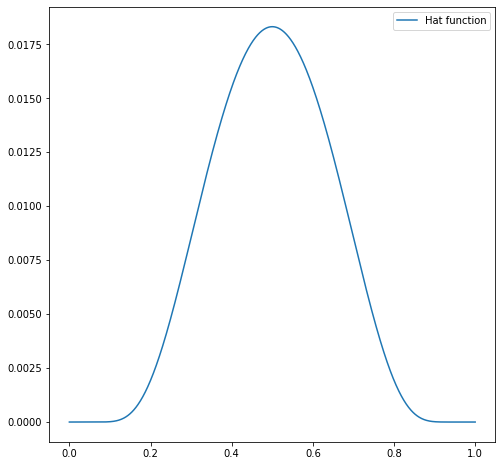

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.plot(
    base_solver.x_grid,
    base_solver.init_condition(base_solver.x_grid), 
    label='Hat function'
)
plt.legend()
plt.show()

In [ ]:
result = solve(base_solver)
np.save('dataset', result.detach().cpu().numpy())

In [ ]:
from datetime import datetime
import os
import cv2

def log_as_video(results, solver, video_name=None):

    # blackpaper function is quite bulky
    # TODO: write a better log function

    date_format = '%Y-%m-%d_%H-%M-%S'
    
    name = os.path.join(
        os.getcwd(), 
        datetime.now().strftime(date_format)
    )

    os.mkdir(name)

    if video_name is None: video_name = name + '.avi'

    # to make the recording faster,
    # take only 1 frame out of 'skip_rate'
    skip_rate = 5

    for i, timestamp in enumerate(results.T[::skip_rate]):

        plt.figure(figsize=(8, 8))
        plt.plot(solver.x_grid, timestamp, label='Numerical solution')
        plt.suptitle(f't = {round(i * solver.tau * skip_rate, 4)}', fontsize=16)
        plt.ylim((0.0, 0.02))
        plt.savefig(os.path.join(name, f'{i}.png'))
        plt.close()

    images = [img for img in os.listdir(name) if img.endswith(".png")]
    images = sorted(
        images, key=lambda x: os.path.getctime(os.path.join(name, x)))
    frame = cv2.imread(os.path.join(name, images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(video_name,
                            cv2.VideoWriter_fourcc(*'mp4v'), 20.0,
                            (width,height))

    for image in images:
       video.write(cv2.imread(os.path.join(name, image)))

    cv2.destroyAllWindows()
    video.release()

    os.system(f'rm -r {name}')


log_as_video(result, base_solver, video_name='base.mp4')

In [ ]:
from IPython.display import HTML
from base64 import b64encode

mp4 = open('base.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:
import os
import torch

from torch.utils.data import Dataset

def get_proj(u): return u[500]

class PDEDataset_full(Dataset):
    """
    Simple version of dataset for the case when 
    observations all over the grid are available. 
    Training objects are triplets (n, u_n, u_{n+1})
    """

    def __init__(self, filename):
        target    = np.load(filename)
        self.u_0  = torch.from_numpy(target[:,:-1]).float()
        self.u_1  = torch.from_numpy(target[:,1:]).float()
        self.size = target.shape[1] - 1
        
    def __len__(self): return self.size

    def __getitem__(self, i): return i, self.u_0[:, i], self.u_1[:, i]


class PDEDataset_obs(Dataset):

    def __init__(self, filename):
        self.u_0 = np.load(filename)
        self.size = self.u_0.shape[1] - 1
        
    def __len__(self): return self.size

    def __getitem__(self, i): return i, get_proj(self.u_0[:, :i+1])


def batcher(batch):

    times  = [t[0] for t in batch]
    slices = [t[1] for t in batch]

    return times, slices 

In [ ]:
import torch
import torch.nn as nn

class ParameterizedTS(nn.Module):
    """ 
    A simple neural net representing the 'a(x)' function
    """
  
    def __init__(self, device, h_units=64):

        super().__init__()

        self.device = device
        self.h_units = h_units

        self.net = nn.Sequential(
              nn.Linear(1, self.h_units),
              nn.ReLU(),
              nn.Linear(self.h_units, self.h_units),
              nn.ReLU(),
              nn.Linear(self.h_units, 1),
              nn.Sigmoid()
        )

    def to(self, device):
        super().to(device)
        self.device = device

    def forward(self, x):
        x = x.to(self.device).float().unsqueeze(-1)
        return 2 * self.net(x).squeeze(-1) # prior assumption

In [ ]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import clear_output

def train_full(model, solver, opt, num_epochs, data_loader, checkpoint_name):
    """
    Traning function for the case when all the observations are available
    """

    model.to(device)
    loss    = nn.MSELoss()
    history = []

    for i in range(num_epochs):

        loss_epoch = []
    
        for i, batch in enumerate(tqdm(data_loader, desc='Training')):

            opt.zero_grad()
            ts = model.forward(solver.x_grid.to(device))
            solver.update_transfer_speeds(ts)

            loss_value = 0

            n   = batch[0]
            u0  = batch[1].to(device)
            u1  = batch[2].to(device)

            preds      = solver.timestep(n, u0)        
            loss_value = loss(preds, u1)
            
            loss_value.backward()
            opt.step()
            loss_epoch.append(loss_value.cpu().data.numpy())
            torch.cuda.empty_cache()

        torch.save(model.state_dict(), checkpoint_name)
        history.append(np.mean(loss_epoch))
       
        clear_output(wait=True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()
        
    return history

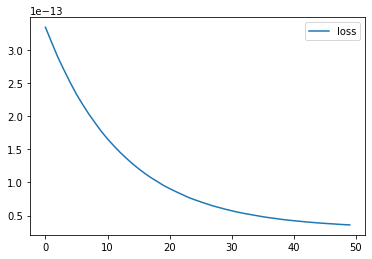

In [ ]:
from torch.optim import Adam

dataset_full = PDEDataset_full('dataset.npy')
g_full = torch.utils.data.DataLoader(
    dataset_full, batch_size=32, shuffle=True, num_workers=5)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
solver_full = RightCornerSolver(
    (0.0, 1.0), # domain 
    (0.0, 1.0), # interval
    hat_f, # initial condition
    lambda x: const_f(x, const=0.) # boundary condition
)

model_full = ParameterizedTS(device)

opt        = Adam(model_full.parameters(), lr=1e-2)
checkpoint = os.path.join(os.getcwd(), 'full.pth')
loss_history = train_full(
    model_full, solver_full, opt, 50, g_full, checkpoint)

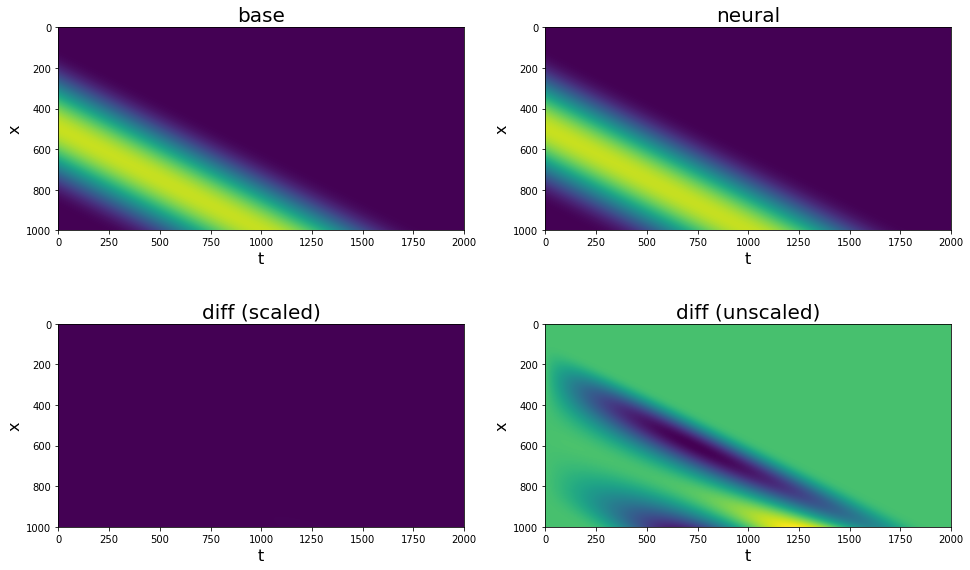

In [ ]:
def plot_solutions(base_solver, neural_solver):

    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(16, 10))

    base   = solve(base_solver)

    with torch.no_grad(): neural = solve(neural_solver)

    axs[0][0].imshow(base, vmin=0, vmax=0.02)
    axs[0][0].set_title('base', fontsize=20)
    axs[0][0].set_xlabel('t', fontsize=16)
    axs[0][0].set_ylabel('x', fontsize=16)

    axs[0][1].imshow(base, vmin=0, vmax=0.02)
    axs[0][1].set_title('neural', fontsize=20)
    axs[0][1].set_xlabel('t', fontsize=16)
    axs[0][1].set_ylabel('x', fontsize=16)

    axs[1][0].imshow(base - neural, vmin=0, vmax=0.02)
    axs[1][0].set_title('diff (scaled)', fontsize=20)
    axs[1][0].set_xlabel('t', fontsize=16)
    axs[1][0].set_ylabel('x', fontsize=16)

    axs[1][1].imshow(base - neural)
    axs[1][1].set_title('diff (unscaled)', fontsize=20)
    axs[1][1].set_xlabel('t', fontsize=16)
    axs[1][1].set_ylabel('x', fontsize=16)

    plt.show()

plot_solutions(base_solver, solver_full)

In [ ]:
def train_partial(model, solver, opt, num_epochs, data_loader, checkpoint_name):

    model.to(device)
    loss   = nn.MSELoss()
    history = []

    for i in range(num_epochs):

        loss_epoch = []
    
        for i, batch in enumerate(tqdm(data_loader, desc='Training')):

            opt.zero_grad()
            ts = model.forward(solver.x_grid)
            solver.update_transfer_speeds(ts)

            loss_value = 0.

            for n, u1 in zip(batch[0], batch[1]):
              
              u0 = solver.init_condition(solver.x_grid).to(device)
              for i in range(1, n): u0 = solver.timestep(i, u0)

              u1 = torch.tensor(u1[-1]).to(device)
              loss_value += loss(get_proj(u0), u1)
          
            loss_value.backward()
            opt.step()
            loss_epoch.append(loss_value.cpu().data.numpy())
            torch.cuda.empty_cache()

        torch.save(model.state_dict(), checkpoint_name)
        history.append(np.mean(loss_epoch))
       
        clear_output(wait=True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()
        
    return history

In [ ]:
dataset_obs = PDEDataset_obs('dataset.npy')
g_obs = torch.utils.data.DataLoader(
    dataset_obs, batch_size=32, shuffle=True, num_workers=5, collate_fn=batcher)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

solver_partial = RightCornerSolver(
    (0.0, 1.0), # domain 
    (0.0, 1.0), # interval
    hat_f, # initial condition
    lambda x: const_f(x, const=0.), # boundary condition
     # parameterized transfer speed
)

model_partial = ParameterizedTS(device)
opt  = Adam(model_partial.parameters(), lr=1e-3)
checkpoint = os.path.join(os.getcwd(), 'partial.pth')
loss_history = train_partial(
    model_partial, solver_partial, opt, 3, g_obs, checkpoint)

In [ ]:
with torch.no_grad():
    log_as_video(solve(solver_partial), solver_partial, video_name='partial.mp4')

The second training technique looks like a practical case.
However, this approach leads to following drawbacks:
1. We need a solver written in a tensor framework for a FDS
2. We need to backpropagate through computational graph of solver iterations, which is quite costy

#### There exists a roundabout, that can resolve both of this problems

We will make use of adjoint method for optimization with functional constraints. For the detailed descriptioin of the metod refer to https://cs.stanford.edu/~ambrad/adjoint_tutorial.pdf

We reformulate our problem in the following form

\begin{gather*}
\text{L} \left( u, \{\hat{u}(t_i)\} \right) \rightarrow \min_{a} \\
 h(u, u_t, a(x, \theta), t) = \text{FDS} \left(u, u_t, a(x, \theta), t \right) = 0 \\
 g(u_0, a) = 0 \\ 
\end{gather*}

Here $g(u_0, a)$ represents the array of initial and boundary conditions.
**We must also require the FDS to be semi-discrete with respect to the spatial variables**

It can be shown, that in case, when 
$$L = \int \limits_{0}^{T} f(u, t, a) dt $$
the gradient of loss w.r.t $a$ is given by 
$$
\frac{dL}{da}= \int \limits_{0}^{T} \left(f_a + \lambda^T \partial_a h \right) dt + \left.\lambda^T \partial_{u_t} h \right \vert_0 {g_{u_0}^{-1}} g_a \quad (1)\\  
$$

Where $\lambda = \lambda(t) $ satisfies
$$
\partial_u f + \lambda^T (\partial_u h − d_t \partial_{u_t}h) − \dfrac{d\lambda^T}{dt} \partial_{u_t}h = 0 \quad (2)
$$

#### We can calculate the gradient of the loss function w.r.t $\theta$ the following way

1. Integrate equation for $h$
2. Calculate following derivatives
$$\partial_u f, \, \partial_u h, \, \partial_{u_t}h, \, f_a, \, \partial_a h $$ 
3. Solve equation (2) backwards in time w.r.t $\lambda$
4. Use equation (1) to find $\dfrac{dL}{da}$
5. Apply chain rule
$$
\dfrac{dL}{d\theta} = \dfrac{dL}{da(\theta)} \dfrac{da}{d\theta}
$$

Note that this procedure
1. Allows us to treat solver "almost" as a blackbox (the only concern here is $\partial_a h$)
2. Allows us to get rid of backpropagation through solver
  
We may further simplify the computation of gradient, if we make following assumptions:

1. FDS can be written in the form
$$ u_t - A(a) u = 0 $$
Here A(a) is a linear operator, spacially discretisizing the PDE
2. $f(u, t, a) = f(u,t)$
3. $g(u_0, a) = g(u_0)$

Hence, we have

\begin{gather*}
\partial_{u_t} h = 1 \\
\partial_{u} h = -\partial_{u} \left(A(a) u \right)) = -A(a)\textbf{1} = 0 \\
\partial_a g = 0 \\
\partial_a f = 0 \\
\end{gather*}

For the initial-boundary value problem considered above, we get 
\begin{gather*}
\dfrac{d\lambda^T}{dt} = \partial_{u} f \\
\partial_{a} h = -\partial_a A(a) u = -\dfrac{\tau}{h} \left(u(x) - u(x - h) \right) \\
\frac{dL}{da}= \dfrac{\tau}{h} \int \limits_{0}^{T} \lambda^T \left(u(x-h) - u(x) \right) dt 
\end{gather*}


Up to weight factors, minimizing MSE loss function is equivalent to minimization of numerical integral

$$ MSE(u, {\hat{u} (t_i)}) \simeq \dfrac{1}{2} \int \limits_{0}^{T} \left( \text{proj} \left(u(t) \right) - \hat{u}(t) \right)^2 dt $$

Here $\text{proj} (\cdot)$ is the projection operator.
Hence, 
\begin{gather}
\partial_u f(t) = \left( \text{proj} \left( u(t) \right) - \hat{u}(t) \right) \partial_u \text{proj} \left( u(t) \right) \\
\lambda^T(t) = -\int \limits_{t}^{T} dt \left( \left( \text{proj} \left( u(t) \right) - \hat{u}(t) \right) \partial_u \text{proj} \left( u(t) \right) \right)
\end{gather}

In [ ]:
from tqdm.notebook import tqdm
from IPython.display import clear_output

def integrate_backwards_in_time(a, b, dt):

    result   = torch.zeros(a.shape)
    
    # we'll explicit Euler scheme for simplicity
    for i in range(a.shape[1] - 2, 0, -1):

        result[:, i] = result[:, i+1] +\
            -dt * (a[:, i] * b[i])
    
    return -result

def integrate_trapezioid(u, tau):

    return tau * (
        (u[:, 0] + u[:, -1]) / 2. + torch.sum(u[:, 1:-1], axis=1)
    )

def get_proj_grad(u):

    u = u.detach().clone()
    u.requires_grad = True

    proj = get_proj(u)
    grad = torch.autograd.grad(
      outputs=proj, inputs=u,
      grad_outputs=torch.ones(proj.size()),
      create_graph=False, retain_graph=False, only_inputs=True
    )[0]

    return grad


def train_modified(
    model, solver, opt,
    num_epochs, data_loader, checkpoint_name
):

    model.to(device)
    history = []

    for i in range(num_epochs):

        loss_epoch = []
    
        opt.zero_grad()

        for batch in tqdm(
            data_loader, desc=f'Epoch {i+1} of {num_epochs}'):

            loss_batch = []

            dL_da = []

            ts_grid = model.forward(solver.x_grid.to(device)) 
            solver.update_transfer_speeds(ts_grid)

            u_0 = 0.0
            # integrate equation for h
            with torch.no_grad(): u_0 = solve(solver)
            proj      = get_proj(u_0)
            proj_grad = get_proj_grad(u_0)


            shift = solver.tau / solver.h * (u_0[:-1] - u_0[1:])

            for i, ground_truth in zip(batch[0], batch[1]):

                loss_batch.append(
                    torch.mean((proj[:i+1] - ground_truth) ** 2).cpu().data.numpy()
                )

                lmbda = integrate_backwards_in_time(
                    proj_grad[:, :i+1],  proj[:i+1] - ground_truth,
                    solver.tau
                )

                prod     = shift[:, :i+1] * lmbda[1:] 
                integral = solver.tau / solver.h *\
                           integrate_trapezioid(prod, solver.tau)       
                
                dL_da.append(torch.cat([torch.tensor([0.]), integral], dim=0)) 
                
            print(np.mean(np.array(loss_batch)))
            dL_da = torch.mean(torch.stack(dL_da, dim=0), axis=0).to(device)      
            ts_grid.backward(dL_da)
            opt.step()

        
        loss_epoch.append(np.mean(np.array(loss_batch)))
        torch.cuda.empty_cache()

        torch.save(model.state_dict(), checkpoint_name)
        history.append(np.mean(loss_epoch))
        
        clear_output(wait=True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()
        
    return history

In [ ]:
from torch.optim import Adam

d_adjoint = PDEDataset_obs('dataset.npy')
g_adjoint = torch.utils.data.DataLoader(
    d_adjoint, batch_size=64, shuffle=True, num_workers=5, collate_fn=batcher)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
solver = RightCornerSolver(
    (0.0, 1.0), # domain 
    (0.0, 1.0), # interval
    hat_f, # initial condition
    lambda x: const_f(x, const=0.) # boundary condition
)

model = ParameterizedTS(device)
opt   = Adam(model.parameters(), lr=1e-3)
checkpoint   = os.path.join(os.getcwd(), 'full.pth')
loss_history = train_modified(model, solver, opt, 50, g_adjoint, checkpoint)

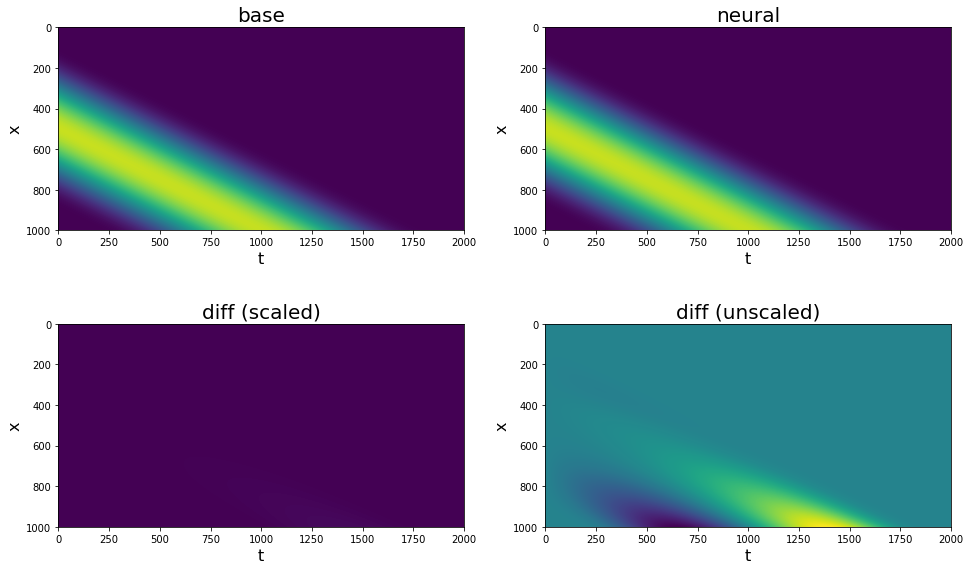

In [ ]:
plot_solutions(base_solver, solver)